## data updates with high frequency for the helioforecast.space website

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'

In [8]:
# https://github.com/cmoestl/heliocats  data_update_web_hf.py

# for updating data with high frequency on the servers

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import sunpy

from heliocats import data as hd
from heliocats import plot as hp

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    %matplotlib inline     


################################################ CHECK  ##############################################

#make sure to convert the current notebook to a script
os.system('jupyter nbconvert --to script data_update_web_hf.ipynb')   

#switches
debug_mode=0

#download and save as pickle
get_noaa=1
get_stereoa=1

####################################################################################################################

#test execution times
t0all = time.time()


system is mac


[NbConvertApp] Converting notebook data_update_web_hf.ipynb to script
[NbConvertApp] Writing 7668 bytes to data_update_web_hf.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(stereoa_path)
print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/insitu_python/ML_struct_arrays/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### positions and SDO plot

 
------ POSITIONS 


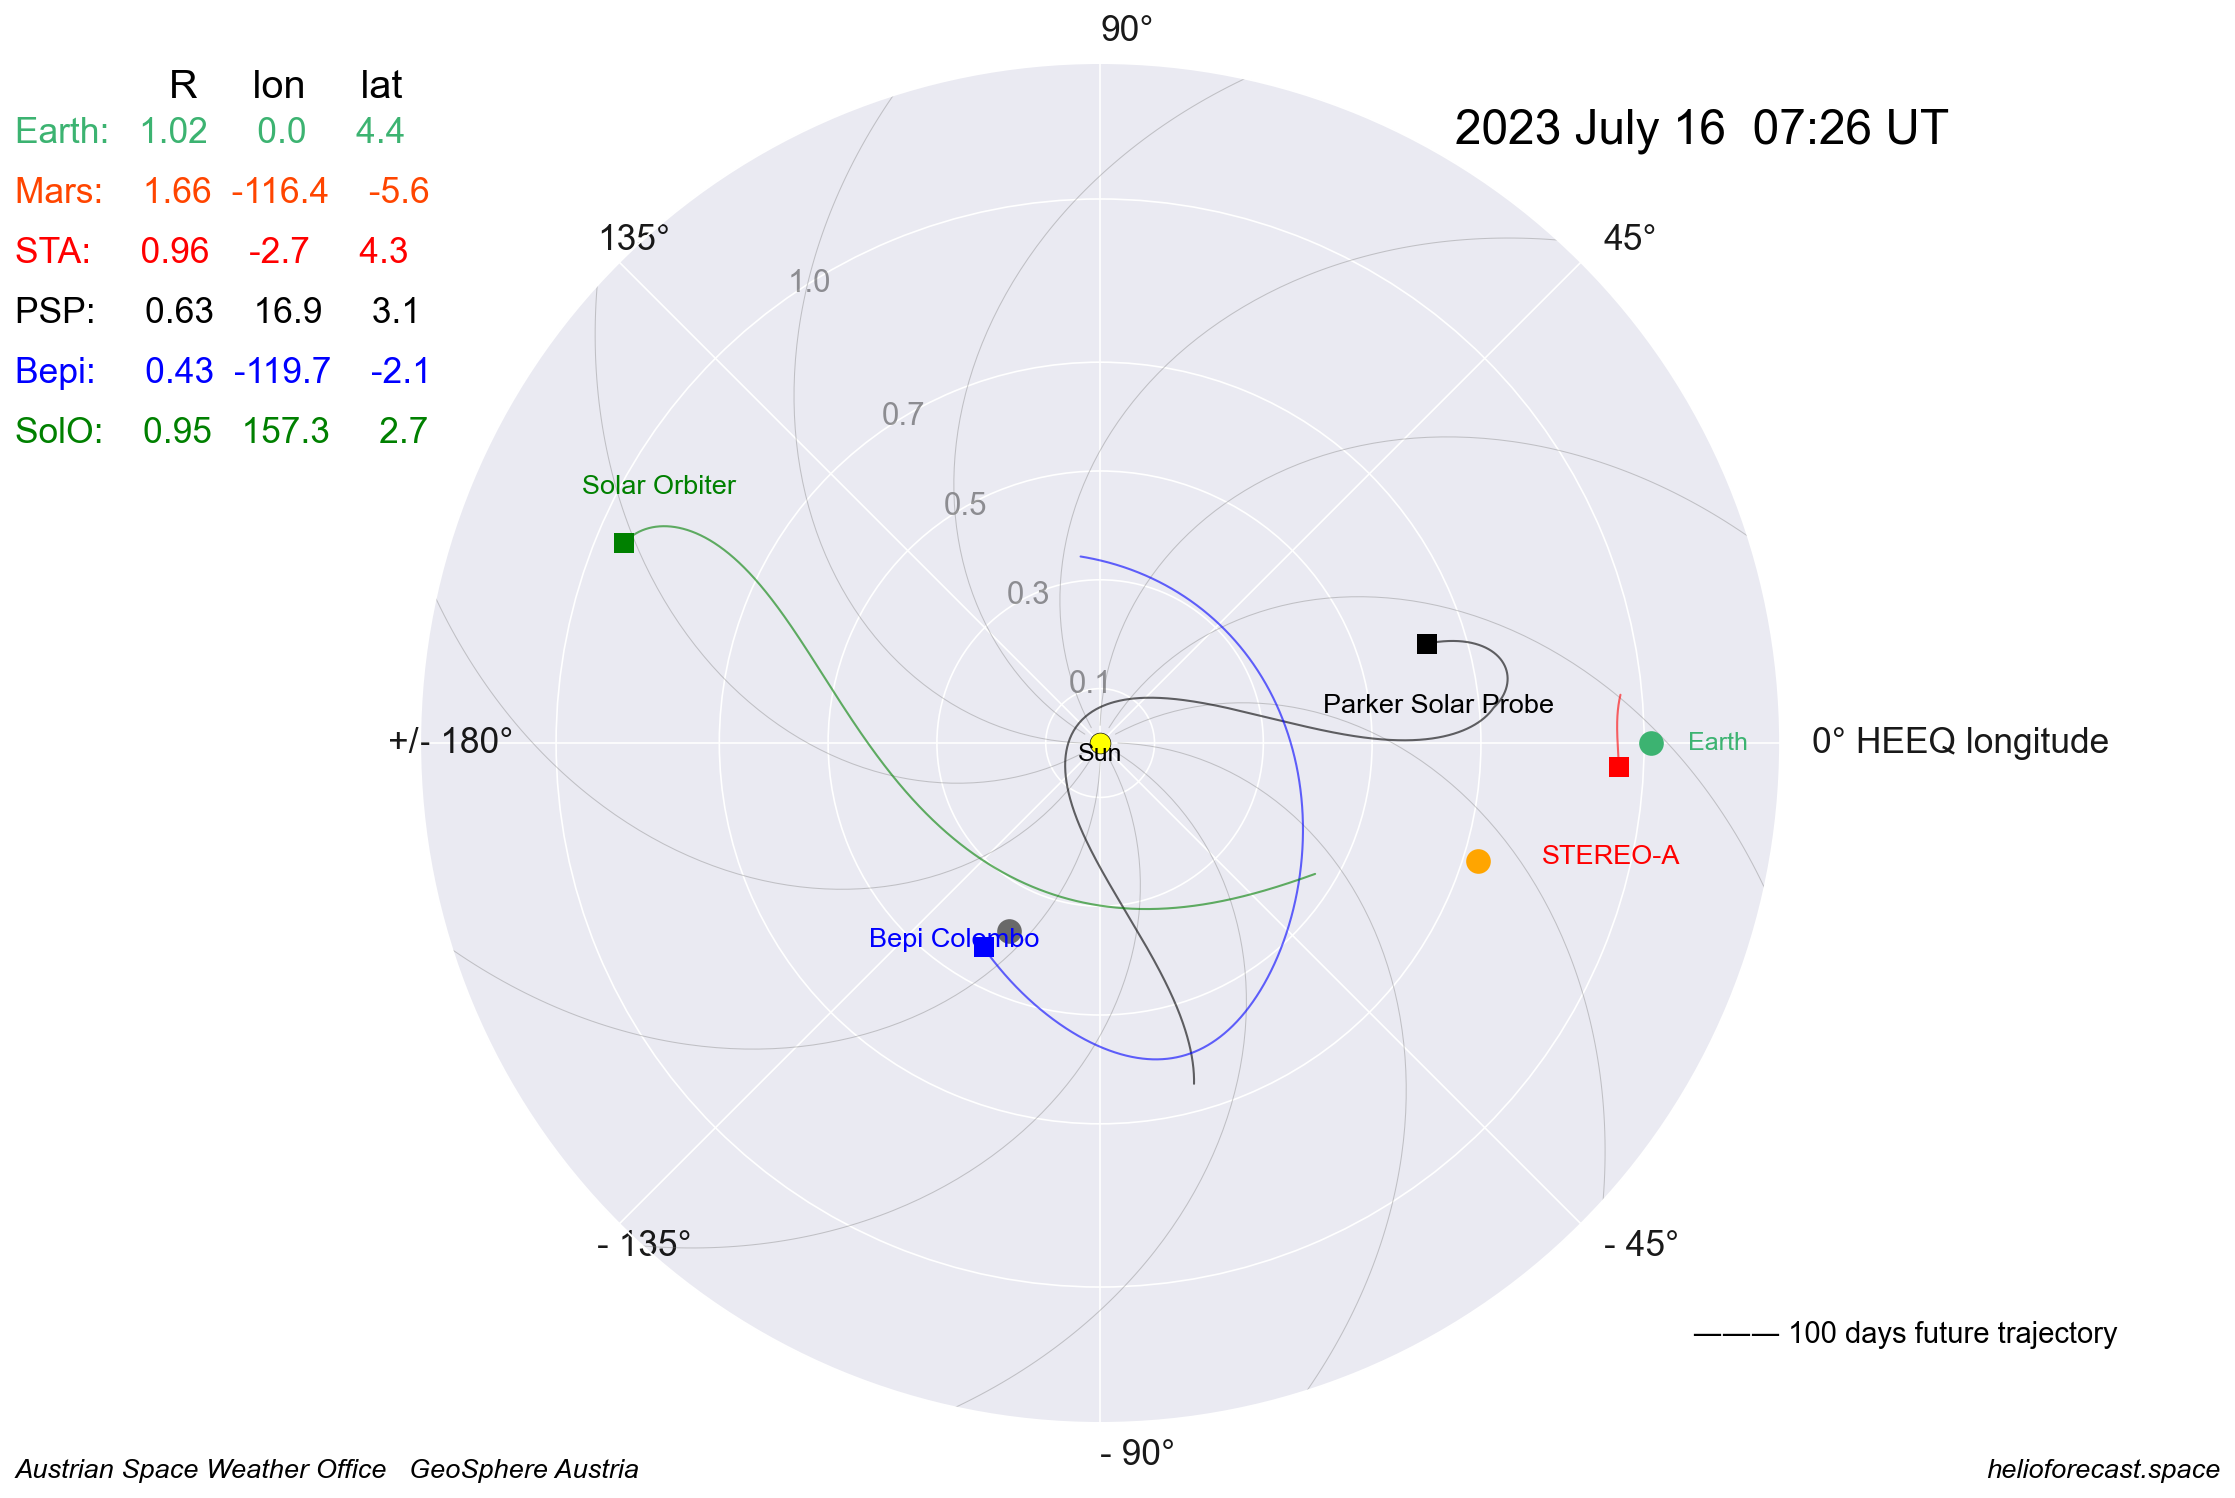

saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_2023_Jul_16.png
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.png
 
------ SDO realtime images 
Failed downloading  https://sdo.gsfc.nasa.gov/assets/img/latest/latest_1024_0193.jpg   <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>

Positions and SDO images takes 5.51 seconds


In [3]:

if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 


t0 = time.time()
print(' ')
print('------ POSITIONS ')

# spacecraft positions image
hp.plot_positions(datetime.datetime.utcnow(),position_path, 'HEEQ',now=True)

print(' ')
print('------ SDO realtime images ')
# get current SDO images 
try:
    hd.get_sdo_realtime_image(sun_path)
except Exception as e: print('SDO not downloaded')  

t1 = time.time()
print()
print('Positions and SDO images takes', np.round(t1-t0,2), 'seconds')

### NOAA real time solar wind and Dst

 
------ NOAA real time solar wind data 
download NOAA real time solar wind plasma and mag and dst
2023-07-16 UTC
/Users/chris/python/ops/data/noaa/plasma/plasma-7-day_2023-07-16.json
/Users/chris/python/ops/data/noaa/mag/mag-7-day_2023-07-16.json
/Users/chris/python/ops/data/noaa/dst/dst-7-day_2023-07-16.json
NOAA RTSW download complete
 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  50  files. 
['mag-7-day_2023-07-02T05h.json' 'mag-7-day_2023-07-02T11h.json'
 'mag-7-day_2023-07-02T17h.json' 'mag-7-day_2023-07-02T23h.json'
 'mag-7-day_2023-07-03T05h.json' 'mag-7-day_2023-07-03T11h.json'
 'mag-7-day_2023-07-03T17h.json' 'mag-7-day_2023-07-03T23h.json'
 'mag-7-day_2023-07-04T05h.json' 'mag-7-day_2023-07-04T11h.json'
 'mag-7-day_2023-07-04T17h.json' 'mag-7-day_2023-07-04T23h.json'
 'mag-7-day_2023-07-05T05h.json' 'mag-7-day_2023-07-05T11h.json'
 'mag-7-day_2023-07-05T1

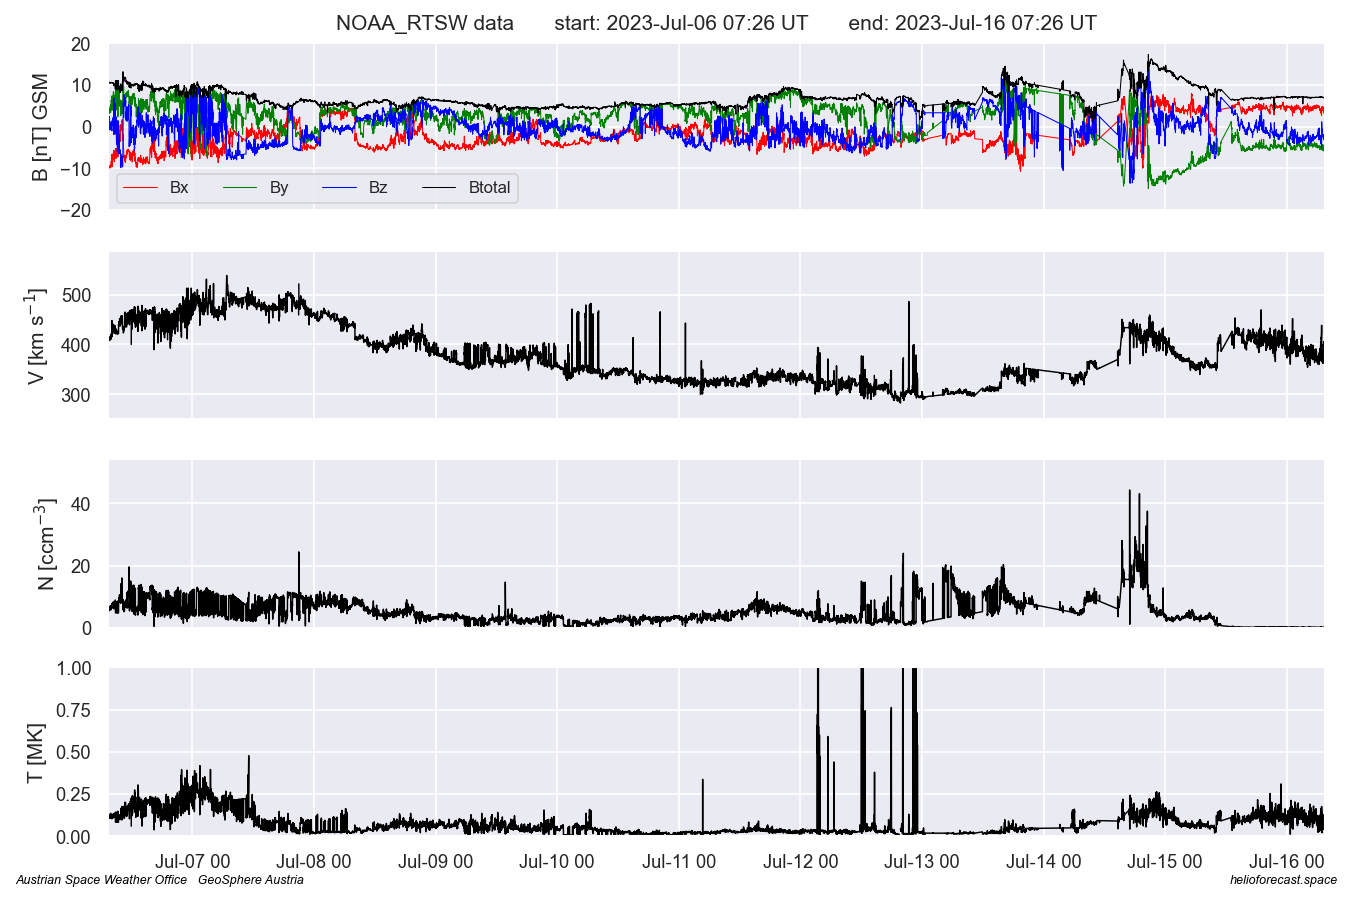

In [4]:
if debug_mode > 0: 
    from heliocats import data as hd
    importlib.reload(hd) 

    from heliocats import plot as hp
    importlib.reload(hp) 

print(' ')
print('------ NOAA real time solar wind data ')

#test execution times
t0 = time.time()


if get_noaa > 0:

    ######## DOWNLOAD NOAA data 
    
    print('download NOAA real time solar wind plasma and mag and dst')
    datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
    print(datestr+' UTC')

    plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
    mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'
    dst='https://services.swpc.noaa.gov/products/kyoto-dst.json'

    try: 
        urllib.request.urlretrieve(plasma, noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
        print(noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', plasma,' ',e.reason)

    try: 
        urllib.request.urlretrieve(mag, noaa_path+'mag/mag-7-day_'+datestr+'.json')
        print(noaa_path+'mag/mag-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
    
    try: 
        urllib.request.urlretrieve(dst, noaa_path+'dst/dst-7-day_'+datestr+'.json')
        print(noaa_path+'dst/dst-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', dst,' ',e.reason)
 
    print('NOAA RTSW download complete')
        
    ######## SAVE NOAA DATA AS PICKLE
    filenoaa='noaa_rtsw_last_50files_now.p'
    # last parameter gives a cutoff, so only the latest N files are taken for the NOAA data pickle file
    hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,50)
    print('NOAA RTSW saved as pickle file complete')
    

else:
    print('NOAA data NOT downloaded and saved as pickle, turn on switch')  


[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

 
#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_noaa_rtsw(noaa, start, end,'NOAA_RTSW',plot_path+'noaa/',now=True)


t1 = time.time()

print()
print('NOAA download, save as pickle and plotting takes', np.round(t1-t0,2), 'seconds')


    

### STEREO-A beacon data

 
------ download STEREO-A beacon data 
 
download STEREO-A beacon data to  /Users/chris/python/data/stereoa/
STA_LB_IMPACT_20230711_V02.cdf
STA_LB_PLASTIC_20230711_V14.cdf
STA_LB_IMPACT_20230712_V02.cdf
STA_LB_PLASTIC_20230712_V14.cdf
STA_LB_IMPACT_20230713_V02.cdf
STA_LB_PLASTIC_20230713_V14.cdf
STA_LB_IMPACT_20230714_V02.cdf
STA_LB_PLASTIC_20230714_V14.cdf
STA_LB_IMPACT_20230715_V02.cdf
STA_LB_PLASTIC_20230715_V14.cdf
STA_LB_IMPACT_20230716_V02.cdf
STA_LB_PLASTIC_20230716_V14.cdf
------ process STEREO-A beacon data to pickle
2023-07-06 07:27:00
2023-07-16 07:27:00
['20230706', '20230707', '20230708', '20230709', '20230710', '20230711', '20230712', '20230713', '20230714', '20230715', '20230716']
STA_LB_IMPACT_20230706_V02.cdf
STA_LB_IMPACT_20230707_V02.cdf
STA_LB_IMPACT_20230708_V02.cdf
STA_LB_IMPACT_20230709_V02.cdf
STA_LB_IMPACT_20230710_V02.cdf
STA_LB_IMPACT_20230711_V02.cdf
STA_LB_IMPACT_20230712_V02.cdf
STA_LB_IMPACT_20230713_V02.cdf
STA_LB_IMPACT_20230714_V02.cdf
STA_LB_IMPACT_

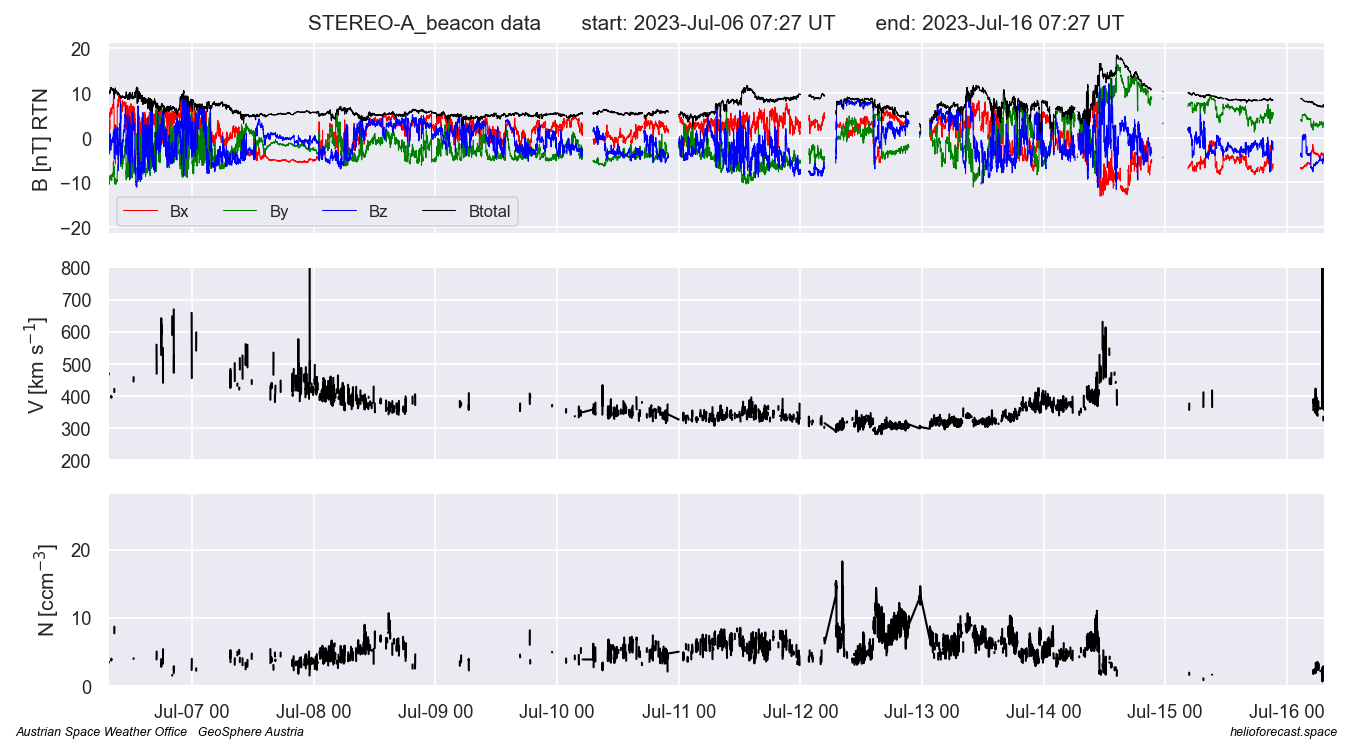

In [5]:

if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    #test execution times
t0 = time.time()


if get_stereoa > 0:

    print(' ')
    print('------ download STEREO-A beacon data ')
    print(' ')
    
    hd.stereoa_download_beacon(start_year=datetime.datetime.utcnow().year,start_month=datetime.datetime.utcnow().month,start_day=datetime.datetime.utcnow().day-5,stereoa_path=stereoa_path)   

    print('------ process STEREO-A beacon data to pickle') 

    #define filename
    file_sta_beacon='stereoa_beacon_last_10days_now.p'   

    #save pickle file
    hd.save_stereoa_beacon_data(data_path,stereoa_path,file_sta_beacon,datetime.datetime.utcnow()-datetime.timedelta(days=10),datetime.datetime.utcnow(),coord='RTN' )   
    
#load pickle    
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon, "rb" ) )  

#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta, start, end,'STEREO-A_beacon',plot_path+'stereoa/',now=True)
    
    
    
t1 = time.time()

print()
print('STEREO-A beacon downloading current month, save as pickle last 10 days and plotting takes', np.round(t1-t0,2), 'seconds')

## Combined plot STEREO-A NOAA RTSW

saved as  /Users/chris/python/data/insitu_python/plots/combined/NOAA_RTSW_STEREO-A_beacon_2023_Jul_13_2023_Jul_16.png
saved as  /Users/chris/python/data/insitu_python/plots/combined/NOAA_RTSW_STEREO-A_beacon_now.png


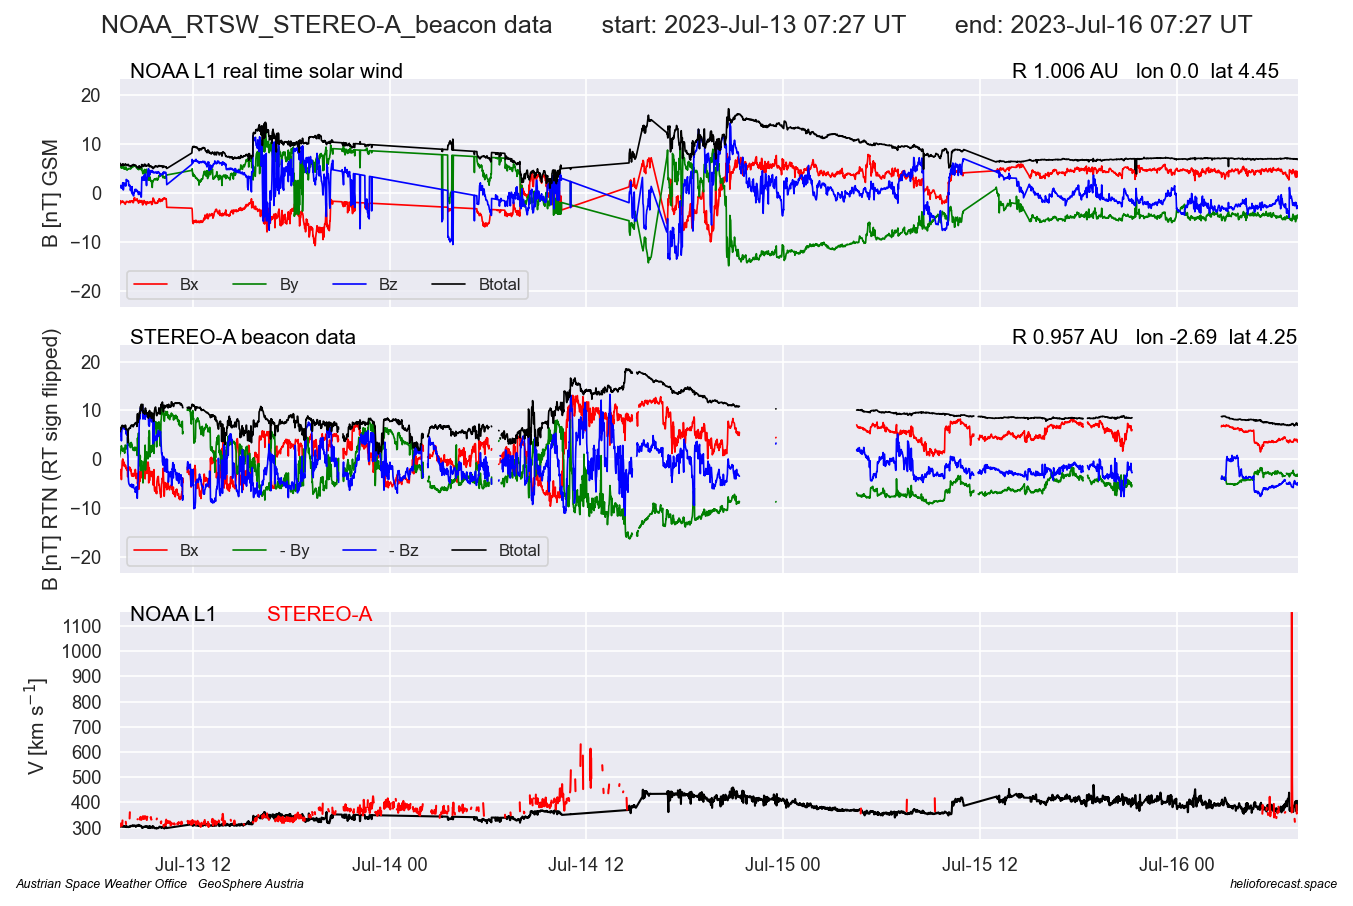

In [6]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

start=datetime.datetime.utcnow() - datetime.timedelta(days=3)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_noaa(noaa, sta, start, end,'NOAA_RTSW_STEREO-A_beacon',plot_path+'combined/',now=True)
    

In [7]:
t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full high frequency data update:', np.round((t1all-t0all),2), 'seconds')
print('--------------------------------------------------------------------------------------')

 
 
 
------------------
Runtime for full high frequency data update: 93.98 seconds
--------------------------------------------------------------------------------------
